<a href="https://colab.research.google.com/github/AnaBelenCarbajal/Thesis/blob/main/Interpolation_catLearningTask_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset novel shapes - Trainig**

1) Installing packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install osculari

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvi

In [3]:
#packages
import osculari
from osculari.paradigms.forced_choice import paradigm_utils
import torch.nn as nn

import os
import pandas as pd
import torch
import numpy as np
from matplotlib import pyplot as plt

from random import choice
import torchvision.transforms.functional as transform
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import v2
from torchvision.transforms import Pad
from torch.utils.data import DataLoader

from PIL import Image

In [4]:
# unzip folder (previously uploaded in collab)
!unzip '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/CategoryLearningStimuli.zip' -d my_data

Archive:  /content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/CategoryLearningStimuli.zip
   creating: my_data/CategoryLearningStimuli/
  inflating: my_data/__MACOSX/._CategoryLearningStimuli  
  inflating: my_data/CategoryLearningStimuli/348.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._348.png  
  inflating: my_data/CategoryLearningStimuli/360.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._360.png  
  inflating: my_data/CategoryLearningStimuli/176.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._176.png  
  inflating: my_data/CategoryLearningStimuli/88.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._88.png  
  inflating: my_data/CategoryLearningStimuli/162.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._162.png  
  inflating: my_data/CategoryLearningStimuli/189.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._189.png  
  inflating: my_data/CategoryLearningStimuli/77.pn

In [5]:
# root directory to data
root = "my_data/CategoryLearningStimuli/"
dic_pretraining = '/content/drive/MyDrive/Thesis/Neural_network/Pre-training on Animals shapes/'
dic_training = '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/'

In [6]:
# get category labels
image_ID = os.listdir(root)

#remove ".DS_Store"
image_ID.remove(".DS_Store")
#image_ID.remove(".ipynb_checkpoints")

2) Defining parameters

In [7]:
# conditions
condition1 = {
    'A':[-30, 30],  #low var
    'D':[-80, 80]   #high var
    }

condition2 = {
    'A':[-80, 80], #high var
    'D':[-30, 30]  #low var
    }

In [8]:
# reference shapes angles --> categories
reference_shapeA = 0
reference_shapeB = 310
reference_shapeC = 260
reference_shapeD = 210

3) Get angles and directory

In [9]:
# get angles
angles = []
for image in image_ID:
  get_angle = image.replace('.png', '')
  transform_to_int = int(get_angle)
  angles.append(transform_to_int)

In [10]:
# get image directories
img_dir = []

for image in image_ID:
  folder_path = root + image
  img_dir.append(folder_path)

4) Create general dataset

In [11]:
data =  {'angle' : angles,
         'image' : image_ID,
         'img_dir' : img_dir}
# df
df_data = pd.DataFrame(data)
df_data = df_data.sort_values('angle')

In [12]:
# Create dictionary data
def CreateDictionary (dataframe):
  data_dicts = []

  for i in range(len(dataframe)):
    angle = dataframe.iloc[i, 0]
    image = dataframe.iloc[i, 1]
    img_dir = dataframe.iloc[i, 2]

    individual_dic =  {'angle' : angle,
                       'image' : image,
                       'img_dir' : img_dir}

    data_dicts.append(individual_dic)
  return data_dicts

6) Create datasets (4 for each condition)

In [13]:
data_dict = CreateDictionary(df_data)
data_dict[1]

{'angle': 1,
 'image': '1.png',
 'img_dir': 'my_data/CategoryLearningStimuli/1.png'}

7) Create and select random positions for images

In [14]:
# read positions.txt
#read
PATH = '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/positions.txt'
positions = np.loadtxt(PATH)
positions = positions.tolist()
positions = [[int(float(j)) for j in i] for i in positions]
positions[:5]

[[23, 25, 21, 19],
 [26, 26, 18, 18],
 [31, 7, 13, 37],
 [27, 5, 17, 39],
 [31, 10, 13, 34]]

8) Define class for CNN

In [15]:
# function to give 'random' color jitter
import torch
from torchvision import transforms
from torchvision.transforms import functional as F

def compute_parameters(brightness, contrast, saturation, hue): #tuples
  # pool size of static random values
  N_values = 1000

  # Create list of random values
  rng = np.random.default_rng(seed=42)
  brightness = list(rng.uniform(low=brightness[0], high=brightness[1], size=(N_values,)))
  contrast = list(rng.uniform(low=contrast[0], high=contrast[1], size=(N_values,)))
  saturation = list(rng.uniform(low=saturation[0], high=saturation[1], size=(N_values,)))
  hue = hue

  # Define specific jitter values
  brightness_factor = np.random.choice(brightness)  # Change this to your specific value
  contrast_factor = np.random.choice(contrast)    # Change this to your specific value
  saturation_factor = 0.8  # Change this to your specific value
  hue_factor = 0.1         # Change this to your specific value

  return brightness_factor, contrast_factor, saturation_factor, hue_factor


def apply_ColorJitter(tensor, brightness_factor, contrast_factor, saturation_factor, hue_factor):

  # Convert tensor to PIL Image
  pil_image = transforms.ToPILImage()(tensor)

  # Apply the transformations using functional API on PIL image
  jittered_image = F.adjust_brightness(pil_image, brightness_factor)
  jittered_image = F.adjust_contrast(jittered_image, contrast_factor)
  jittered_image = F.adjust_saturation(jittered_image, saturation_factor)
  jittered_image = F.adjust_hue(jittered_image, hue_factor)

  # Convert PIL Image back to tensor
  jittered_tensor = transforms.ToTensor()(jittered_image)

  return jittered_tensor

In [18]:
class ShapeImageDataset (Dataset):

  # __init__
  def __init__(self, length, reference_shape, test_shape, data_dict, positions, transform=None):
    self.length = length
    self.reference_shape = reference_shape
    self.test_shape = test_shape
    self.data = data_dict
    self.transform = transform
    self.positions = positions
    self.left_right = [0,1]

  # __len__
  def __len__(self):
    return self.length

  # function to read images
  def read_image_from_directory(self, img_dir):
    return read_image(img_dir, ImageReadMode.RGB)

  # __getitem__
  def __getitem__(self, idx):

    # img1 should be reference shape
    ref_shape_image = self.data[self.reference_shape]
    ref_shape_angle = ref_shape_image['angle']
    ref_shape_dir = ref_shape_image['img_dir']

    # img2 should be test shape: from all angles
    if self.test_shape > 360:
      test_shape_angle_360 = self.test_shape - 360
    else:
      test_shape_angle_360 = self.test_shape

    test_shape_image = self.data[round(test_shape_angle_360)]
    test_shape_angle = test_shape_image['angle']
    test_shape_dir = test_shape_image['img_dir']

    # read images
    img1 = self.read_image_from_directory(ref_shape_dir)
    img2 = self.read_image_from_directory(test_shape_dir)

    # gt = proportion yes
    gt = 1

    # apply transformations per image pair
    # resize to 180x180
    resize = v2.Resize([180,180])
    img1 = resize(img1)
    img2 = resize(img2)
    # apply padding
    img1_selected_position = choice(self.positions)
    img2_selected_position = choice(self.positions)
    padding_img1 = Pad(padding = img1_selected_position, fill=128)
    padding_img2 = Pad(padding = img2_selected_position, fill=128)
    img1 = padding_img1(img1)
    img2 = padding_img2(img2)

    #apply ColorJitter
    [brightness_factor, contrast_factor, saturation_factor, hue_factor] = compute_parameters(
        brightness=(0.5,0.8), contrast=(0.1,1), saturation=(-0.5,0.5), hue=0)
    img1 = apply_ColorJitter(img1, brightness_factor, contrast_factor, saturation_factor, hue_factor)
    img2 = apply_ColorJitter(img2, brightness_factor, contrast_factor, saturation_factor, hue_factor)

    # apply more transformations
    if self.transform:
      img1 = self.transform(img1)
      img2 = self.transform(img2)

    # left and right positions change randomly
    # return tensors for image 1 and image 2 and a ground truth
    if choice(self.left_right) == 1:
      img_left = img1
      img_right = img2
    else:
      img_left = img2
      img_right = img1

    #return to_grayscale_rgb(img_left), to_grayscale_rgb(img_right), gt
    return img_left, img_right, gt

9) Create datasets of images

In [19]:
# tranformations to images for NN
preprocess = v2.Compose(
    [   v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [32]:
#create dataset for RSB
#parameters: length, reference_shape, test_shape, data_dict, positions, transform=None)
len_dataset = 1000
test_shape = 390
dataset_RSB = ShapeImageDataset(len_dataset, reference_shapeD, test_shape, data_dict, positions, preprocess)

**Plotting Dataset**

In [21]:
# Denormalize tensor
denormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [22]:
from torchvision.transforms import functional as F

def tensor_to_pil(image_tensor):
    return F.to_pil_image(image_tensor)

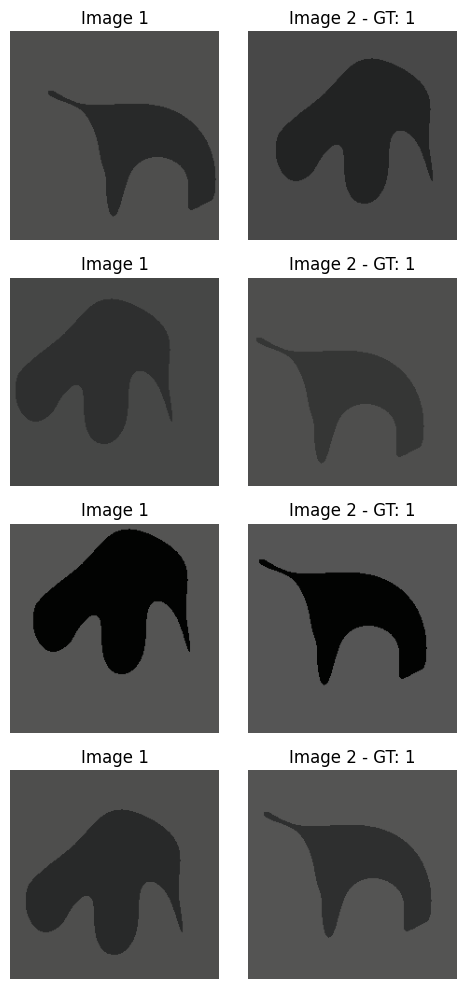

In [34]:
# Example usage to display 5 pairs of images
fig, axs = plt.subplots(4, 2, figsize=(5, 10))

for i in range(4):
    idx = np.random.randint(0, len(dataset_RSB) - 1)
    img1, img2, gt = dataset_RSB[idx]  # Get image pair and ground truth
    img1 = denormalize(img1)
    img2 = denormalize(img2)
    img1_pil = tensor_to_pil(img1)
    img2_pil = tensor_to_pil(img2)

    axs[i, 0].imshow(img1_pil)
    axs[i, 0].set_title('Image 1')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img2_pil)
    axs[i, 1].set_title(f'Image 2 - GT: {gt}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.savefig(dic_training + 'testing_RSD_2.pdf')
plt.show()

**Neural network**

In [35]:
len_dataset = 1000
data = data_dict

In [36]:
test_shapes = [0,10,20,30,40,50,60,70,80,90,100,
               110,120,130,140,150,160,170,180,190,200,
               210,220,230,240,250,260,270,280,290,300,
               310,320,330,340,350]
len(test_shapes)

36

In [37]:
angles =[10,20,30,40,50,60,70,80,90,100,
               110,120,130,140,150,160,170]

angles180 = []
for i in angles:
  i -= 180
  angles180.append(i)
angles_plot = [0] + angles + [180] + angles180
len(angles_plot)

36

In [45]:
def dataset_fun (len_dataset, reference_shape, test_shape, data_dict, positions, preprocess):
    dataset = ShapeImageDataset(len_dataset, reference_shape, test_shape, data_dict, positions, preprocess)
    dataset_loader = DataLoader(dataset, 64)
    return dataset_loader

db_fun = lambda test_shape: dataset_fun(len_dataset, reference_shape, test_shape, data, positions, preprocess)

In [40]:
#load pretrained weights
training_originalmodel_RSA_weights = 'training_originalmodel-RSA.pt'
training_pret_layer0NP_RSA_weights = 'training_pret_layer0NP-RSA.pt'
training_pret_layer1NP_RSA_weights = 'training_pret_layer1NP-RSA.pt'
training_pret_layer2NP_RSA_weights = 'training_pret_layer2NP-RSA.pt'

training_originalmodel_RSD_weights = 'training_originalmodel-RSD.pt'
training_pret_layer0NP_RSD_weights = 'training_pret_layer0NP-RSD.pt'
training_pret_layer1NP_RSD_weights = 'training_pret_layer1NP-RSD.pt'
training_pret_layer2NP_RSD_weights = 'training_pret_layer2NP-RSD.pt'
# load weights
def load_weights(model):
  PATH = dic_training + 'weights training_COND1/' + model
  training_weights = torch.load(PATH)
  return training_weights

In [41]:
training_originalmodel_RSA = load_weights(training_originalmodel_RSA_weights)
training_pret_layer0NP_RSA = load_weights(training_pret_layer0NP_RSA_weights)
training_pret_layer1NP_RSA = load_weights(training_pret_layer1NP_RSA_weights)
training_pret_layer2NP_RSA = load_weights(training_pret_layer2NP_RSA_weights)

training_originalmodel_RSD = load_weights(training_originalmodel_RSD_weights)
training_pret_layer0NP_RSD = load_weights(training_pret_layer0NP_RSD_weights)
training_pret_layer1NP_RSD = load_weights(training_pret_layer1NP_RSD_weights)
training_pret_layer2NP_RSD = load_weights(training_pret_layer2NP_RSD_weights)

In [42]:
def create_dataset(angles, accuracies):
  data = {'angle': angles,
        'accuracy': accuracies}
  data_df = pd.DataFrame(data)
  return data_df

def plot_curve(x, y, title_plot, x_label = 'angle', y_label = 'P(yes)'):
  xpoints = np.array(x)
  ypoints = np.array(y)

  plt.plot(xpoints, ypoints)
  plt.title(title_plot)

  plt.xlabel(x_label)
  plt.ylabel(y_label)

  plt.show()

COND 1

In [43]:
#####################################################################
# RESNET WEIGHTS - NO PRE-TRAINING (and no pooling) layer0
#####################################################################

# network
architecture = 'resnet50'        # network's architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                    # the readout layer
pooling = None
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}

# model with pre-trained weights
original_model_RSA = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)
original_model_RSD = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

# change weights
original_model_RSA.load_state_dict(training_originalmodel_RSA)
original_model_RSD.load_state_dict(training_originalmodel_RSD)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


<All keys matched successfully>

Succes of training

In [46]:
# RS-A
reference_shape = reference_shapeA
model = original_model_RSA

accuracies = []
for test_shape in test_shapes:
  test_epoch_fun = osculari.paradigms.forced_choice.test_dataset(model,
                                                                db_fun(test_shape),
                                                                device="cuda")
  accuracy = test_epoch_fun['accuracy'][-1]
  accuracies.append(accuracy)

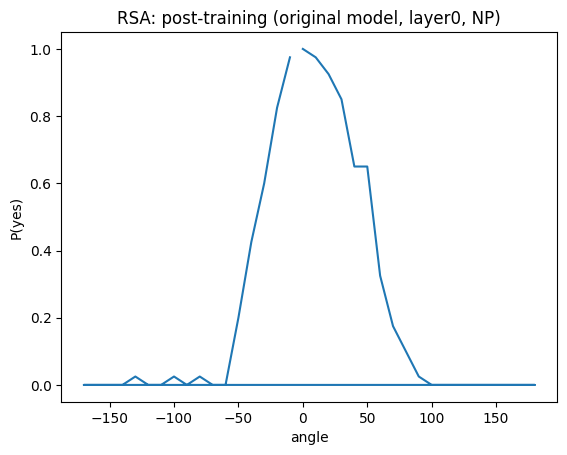

In [47]:
# plot
RSA_testing = create_dataset(test_shapes, accuracies)
RSA_testing['angle180'] = angles_plot
# save as csv
PATH = dic_training + 'POST-TRAINING results/' + 'COND1/' + 'RSA_ORIGINALlayer0_NP.csv'
RSA_testing.to_csv(PATH, index=False)

plot_curve(RSA_testing['angle180'], RSA_testing['accuracy'], "RSA: post-training (original model, layer0, NP)")

In [48]:
# RS-D
reference_shape = reference_shapeD
model = original_model_RSD

accuracies = []
for test_shape in test_shapes:
  test_epoch_fun = osculari.paradigms.forced_choice.test_dataset(model,
                                                                db_fun(test_shape),
                                                                device="cuda")
  accuracy = test_epoch_fun['accuracy'][-1]
  accuracies.append(accuracy)

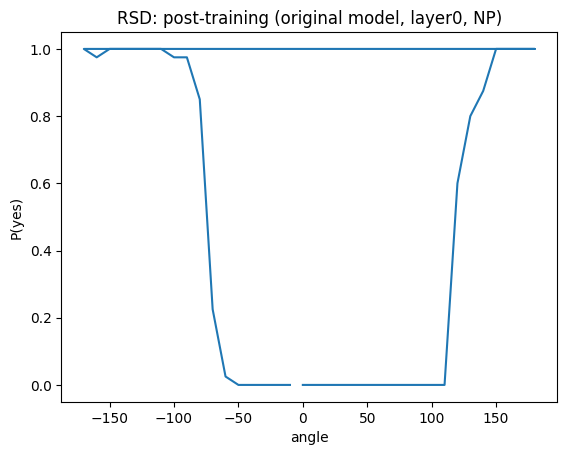

In [49]:
# plot
RSD_testing = create_dataset(test_shapes, accuracies)
RSD_testing['angle180'] = angles_plot
# save as csv
PATH = dic_training + 'POST-TRAINING results/' + 'COND1/' + 'RSD_ORIGINALlayer0_NP.csv'
RSD_testing.to_csv(PATH, index=False)

plot_curve(RSD_testing['angle180'], RSD_testing['accuracy'], "RSD: post-training (original model, layer0, NP)")

Success of interpolation

In [50]:
# RS-B
reference_shape = reference_shapeB
model = original_model_RSA

accuracies = []
for test_shape in test_shapes:
  test_epoch_fun = osculari.paradigms.forced_choice.test_dataset(model,
                                                                db_fun(test_shape),
                                                                device="cuda")
  accuracy = test_epoch_fun['accuracy'][-1]
  accuracies.append(accuracy)

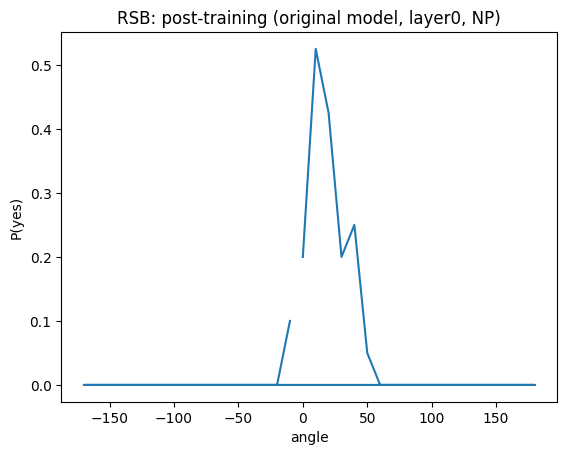

In [51]:
# plot
RSB_testing = create_dataset(test_shapes, accuracies)
RSB_testing['angle180'] = angles_plot
# save as csv
PATH = dic_training + 'POST-TRAINING results/' + 'COND1/' + 'RSB_ORIGINALlayer0_NP.csv'
RSB_testing.to_csv(PATH, index=False)

plot_curve(RSB_testing['angle180'], RSB_testing['accuracy'], "RSB: post-training (original model, layer0, NP)")

In [52]:
# RS-C
reference_shape = reference_shapeC
model = original_model_RSD

accuracies = []
for test_shape in test_shapes:
  test_epoch_fun = osculari.paradigms.forced_choice.test_dataset(model,
                                                                db_fun(test_shape),
                                                                device="cuda")
  accuracy = test_epoch_fun['accuracy'][-1]
  accuracies.append(accuracy)

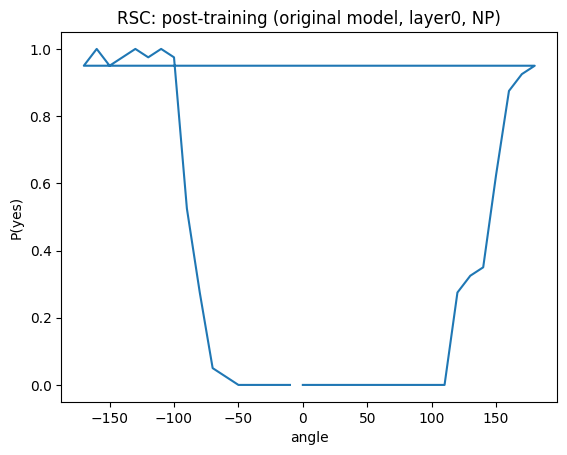

In [53]:
# plot
RSC_testing = create_dataset(test_shapes, accuracies)
RSC_testing['angle180'] = angles_plot
# save as csv
PATH = dic_training + 'POST-TRAINING results/' + 'COND1/' + 'RSC_ORIGINALlayer0_NP.csv'
RSC_testing.to_csv(PATH, index=False)

plot_curve(RSC_testing['angle180'], RSC_testing['accuracy'], "RSC: post-training (original model, layer0, NP)")

In [54]:
#######################
# No pooling, layer 0 - pretrained
#######################
# network
architecture = 'resnet50'        # network's architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                    # the readout layer
pooling = None
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}

# model with pre-trained weights
layer0NP_RSA = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)
layer0NP_RSD = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

# change weights
layer0NP_RSA.load_state_dict(training_pret_layer0NP_RSA)
layer0NP_RSD.load_state_dict(training_pret_layer0NP_RSD)

<All keys matched successfully>

Success of training

In [ ]:
# RS-A
reference_shape = reference_shapeA
model = layer0NP_RSA

accuracies = []
for test_shape in test_shapes:
  test_epoch_fun = osculari.paradigms.forced_choice.test_dataset(model,
                                                                db_fun(test_shape),
                                                                device="cuda")
  accuracy = test_epoch_fun['accuracy'][-1]
  accuracies.append(accuracy)

In [ ]:
# plot
RSA_testing = create_dataset(test_shapes, accuracies)
RSA_testing['angle180'] = angles_plot
# save as csv
PATH = dic_training + 'POST-TRAINING results/' + 'COND1/' + 'RSA_layer0_NP.csv'
RSA_testing.to_csv(PATH, index=False)

plot_curve(RSA_testing['angle180'], RSA_testing['accuracy'], "RSA: post-training (pre-trained, layer0, NP)")

In [ ]:
# RS-D
reference_shape = reference_shapeD
model = layer0NP_RSD

accuracies = []
for test_shape in test_shapes:
  test_epoch_fun = osculari.paradigms.forced_choice.test_dataset(model,
                                                                db_fun(test_shape),
                                                                device="cuda")
  accuracy = test_epoch_fun['accuracy'][-1]
  accuracies.append(accuracy)

In [ ]:
# plot
RSD_testing = create_dataset(test_shapes, accuracies)
RSD_testing['angle180'] = angles_plot
# save as csv
PATH = dic_training + 'POST-TRAINING results/' + 'COND1/' + 'RSD_layer0_NP.csv'
RSD_testing.to_csv(PATH, index=False)

plot_curve(RSD_testing['angle180'], RSD_testing['accuracy'], "RSD: post-training (pre-trained, layer0, NP)")

Success of interpolation

In [ ]:
# RS-B
reference_shape = reference_shapeB
model = layer0NP_RSA

accuracies = []
for test_shape in test_shapes:
  test_epoch_fun = osculari.paradigms.forced_choice.test_dataset(model,
                                                                db_fun(test_shape),
                                                                device="cuda")
  accuracy = test_epoch_fun['accuracy'][-1]
  accuracies.append(accuracy)

In [ ]:
# plot
RSB_testing = create_dataset(test_shapes, accuracies)
RSB_testing['angle180'] = angles_plot
# save as csv
PATH = dic_training + 'POST-TRAINING results/' + 'COND1/' + 'RSB_layer0_NP.csv'
RSB_testing.to_csv(PATH, index=False)

plot_curve(RSB_testing['angle180'], RSB_testing['accuracy'], "RSB: post-training (pre-trained, layer0, NP)")

In [ ]:
# RS-C
reference_shape = reference_shapeC
model = layer0NP_RSD

accuracies = []
for test_shape in test_shapes:
  test_epoch_fun = osculari.paradigms.forced_choice.test_dataset(model,
                                                                db_fun(test_shape),
                                                                device="cuda")
  accuracy = test_epoch_fun['accuracy'][-1]
  accuracies.append(accuracy)

In [ ]:
# plot
RSC_testing = create_dataset(test_shapes, accuracies)
RSC_testing['angle180'] = angles_plot
# save as csv
PATH = dic_training + 'POST-TRAINING results/' + 'COND1/' + 'RSC_layer0_NP.csv'
RSC_testing.to_csv(PATH, index=False)

plot_curve(RSC_testing['angle180'], RSC_testing['accuracy'], "RSC: post-training (pre-trained, layer0, NP)")